In [ ]:
# default_exp simulation

# Simulation

> Tools for  simulating cellular vertex dynamics. Iterative algorithm implementations, cell monolayer generators (vertices). (anything else to add?!)

- numerical integration method(s)
    - Euler's method
    - any other approximation?
- implement functions for checking:
    - vertex configuration (for high tension cases there might be overlapping, or twisted cells which are considered illigal by the model)
    - update steps that implement required vertex check, and any other checks needed before accepting vertex position update
- implement Voronoi cell generator for different cell configuration cases (random, evenly spaced, concave cell, ...)

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from vertex_simulation.primitives import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch, numpy as np, matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d

## Euler's method

In [ ]:
# define function for numerical integration

## Cell monolayer graph generators

In [ ]:
#export
def unit_hex_seeds(Sx,Sy):
    '''Produces seed locations for Voronoi such that Voronoi regions 
    form rectangle of hexagonal cells with unit side length (==1).
    
    Arg-s:
    - `Sx`, `Sy`: width (x-axis) and height (y-axis) in cells (assumes that both $S_{x,y}>0$)
    
    Returns:
    - `numpy` array with `Sx`x`Sy` rows and 2 columns.
    '''
    # for regular hexagons with unit length edges
    dXY = [np.sqrt(3), 1.5] # original grid spacing
    x_offset = np.sqrt(3)/2 # moves alter-g rows to the right (+ x-axis)
    X,Y = np.meshgrid(np.linspace(0,(Sx-1)*dXY[0],Sx),np.linspace(0,(Sy-1)*dXY[1],Sy))
    X[1::2,:]+=x_offset
    return np.concatenate((X.ravel()[:,np.newaxis],Y.ravel()[:,np.newaxis]),axis=1)



def mask2vrn_region(verts,vrn_regions,row_mask):
    '''Apply mask to Voronoi regions and vertices and re-label them.
    
    In addition to the `row_mask` (for vertices), also removes empty regions
    and regions with "-1" Voronoi vertices.
    
    Arg-s:
    - `verts` : Voronoi vertex locations (`numpy` array).
    - `vrn_regions`: Voronoi regions ("cells"). Empty regions and
    out-of-diagram Voronoi regions with "-1" vertices are removed.
    - `row_mask`: 1-d binary mask for `verts` rows.
    
    Returns:
    - `v_x` : vertices after applying the mask (`=verts[row_mask,:]`)
    - `regions`: re-labelled regions (with updated vertex indices) 
    '''
    v_x = verts[row_mask,:]
    idx_0    = np.arange(verts.shape[0])
    idx_keep = idx_0[row_mask]
    idx_new    = np.arange(idx_keep.shape[0])
    # hexagon regions
    regions = [[idx_new[idx_keep==v].item() for v in r] for r in vrn_regions
               if len(r) and (-1 not in r) and np.all(row_mask[r])]
    return v_x, regions

In [ ]:
# export
def unit_hexagons(Ny,Nx):
    '''Produces Ny rows-by-Nx columns of hexagons with unit length edges.
    
    Uses scipy.spatial.Voronoi, then trims non-hexagon edge cells and vertices.
    
    Returns:
    - `v_x`: vertex locations, Mx2 `numpy` array (M number of vertices)
    - `regions`: cell vertices (Voronoi regions; list of lists)
    '''
    def hex_mask_(verts,Nx,l_tol = 0.0001):
        '''Mask for vertices forming closed hexagons'''
        # mask for removing vertices pentagon region tips (left and right sides)
        mask_hex = np.logical_and(verts[:,0]>0, verts[:,0]<(Nx+1.5)*np.sqrt(3))
        v_x = verts[mask_hex,:]
        # remove corner vertices (not forming hexagons)
        Xmin =(1.+l_tol)*v_x.min(axis=0)
        Xmax =(1.-l_tol)*v_x.max(axis=0)
        left_btm = np.logical_not(np.logical_and(verts[:,0]<Xmin[0],verts[:,1]<Xmin[1]))
        left_top = np.logical_not(np.logical_and(verts[:,0]<Xmin[0],verts[:,1]>Xmax[1]))
        rght_top = np.logical_not(np.logical_and(verts[:,0]>Xmax[0],verts[:,1]>Xmax[1]))
        mask_cor = np.logical_and(np.logical_and(left_btm,left_top),rght_top)
        # full mask
        return np.logical_and(mask_hex,mask_cor)
    
    Xseed = unit_hex_seeds(Nx+2,Ny+2)
    vrn = Voronoi(Xseed)
    vrn_mask = hex_mask_(vrn.vertices,Nx)
    v_x,regions = mask2vrn_region(vrn.vertices,vrn.regions,vrn_mask)
    return v_x,regions

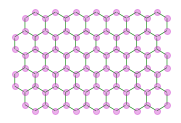

In [ ]:
v_x,regions =unit_hexagons(5,7)
edge_list,cells = VoronoiRegions2Edges(regions)

plt.figure(figsize=[3,2])
plot_graph_as_quiver(Graph(Vertex(v_x),torch.tensor(edge_list)))
plt.plot(v_x[:,0],v_x[:,1],'mo',alpha=.3)
plt.show()

In [ ]:
#hide
# v_seeds = np.array([[np.sqrt(3)/2,5.5], [1.5*np.sqrt(3),5.5], [0.,4.],
#                   [np.sqrt(3),4.],[2*np.sqrt(3),4.],[-np.sqrt(3)/2,2.5],
#                   [np.sqrt(3)/2,2.5],[1.5*np.sqrt(3),2.5],[2.5*np.sqrt(3),2.5],
#                   [0.,1.],[2*np.sqrt(3),1.], [np.sqrt(3),1.]])

# vrn = Voronoi(v_seeds)
# voronoi_plot_2d(vrn)
# ax_lims = plt.axis()
# plt.show()

# edge_list,cells = VoronoiRegions2Edges(vrn.regions) # convert regions to edges and cells
# # print(cells)

In [ ]:
#hide
# edge_list,cells = VoronoiRegions2Edges(regions)

# verts = Vertex(v_x)
# edges = torch.tensor(edge_list)

# plt.figure(figsize=[15,15])
# plot_graph(verts.x,edges)

# # vertex indices
# for k,v in enumerate(v_x):
#     plt.text(v[0]+.1,v[1]+.1,f"{k}",c='b',ha='center',alpha=.5)

# # cell edges
# for c in cells:
#     cell_edges = edges[np.abs(cells[c])-1,:] # edge indices (without direction)
#     if np.any(np.sign(cells[c])<0):
#         # reverse vertex order for negative edges
#         tmp = cell_edges[np.sign(cells[c])<0,:].clone()
#         cell_edges[np.sign(cells[c])<0,0]=tmp[:,1]
#         cell_edges[np.sign(cells[c])<0,1]=tmp[:,0]
#     cell_xy = torch.mean(verts.x[cell_edges[:,0],:],0)
#     for e in cell_edges:
#         e_xy = torch.mean(verts.x[e,:],0)*.65+cell_xy*.35
#         plt.text(e_xy[0],e_xy[1],f"{e.numpy()}",ha='center')
# plt.show()

area:$A_{hex}=\frac{3\sqrt{3}}{2}l_{side}$

- on CPU (my mac) :
    - ~9 mins for 2^15 iter-s **5x5** cells
    - ~40 mins for 2^15 iter-s **10x10** cells

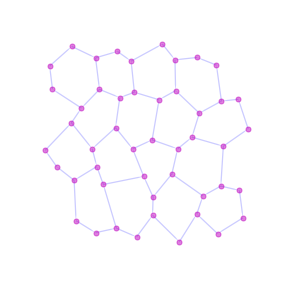

Integration (Euler's method):


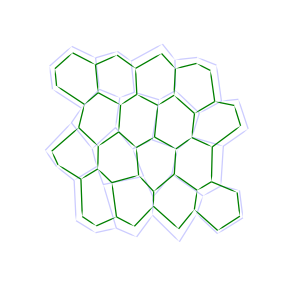

t=1.625: E=5.154; aver |dx/dt|= 0.037


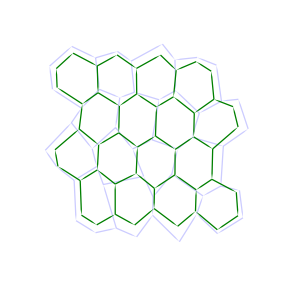

t=4.812: E=5.062; aver |dx/dt|= 0.012


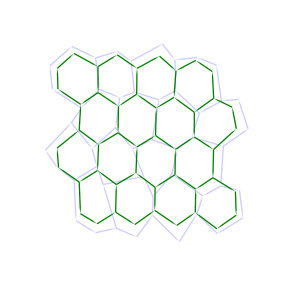

t=9.625: E=5.038; aver |dx/dt|= 0.0063


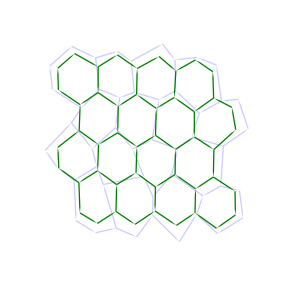

t=12.812: E=5.032; aver |dx/dt|= 0.0045


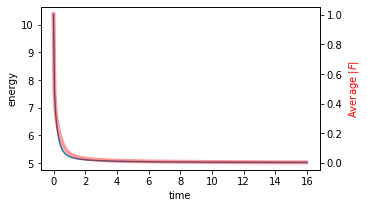

Perimeters:tensor([5.5648, 5.5661, 5.5691, 5.5705, 5.5634, 5.5633, 5.5635, 5.5632, 5.5654,
        5.5618, 5.5667, 5.5624, 5.5712, 5.5628, 5.5638, 5.5587],
       dtype=torch.float64)
Areas:tensor([2.2334, 2.2326, 2.2328, 2.2312, 2.2322, 2.2323, 2.2316, 2.2316, 2.2315,
        2.2321, 2.2319, 2.2320, 2.2321, 2.2325, 2.2328, 2.2290],
       dtype=torch.float64)


In [ ]:
#hide
v_x,regions =unit_hexagons(4,4)
# let's seed RNG for sanity and reproducibility
np.random.seed(42)
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

edge_list,cells = VoronoiRegions2Edges(regions)
# using Voronoi tesselation from above:
verts = Vertex(v_x)
edges = torch.tensor(edge_list)

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=edges, cells=cells)
init_state = Graph(vertices=Vertex(v_x.copy()), edges=edges)
quiver_kwargs={'units': 'xy', 'angles': 'xy', 'scale_units': 'xy',
               'scale': 1.0, 'headwidth': 0, 'headlength': 0, 
               'width': 0.05, 'color': 'b','alpha':.2}
cell_graph.vertices.requires_grad_(True)

# initial state
figsize=[5,5]
plt.figure(figsize=figsize)
plot_graph_as_quiver(cell_graph,quiver_kwargs=quiver_kwargs)
plt.plot(cell_graph.vertices.x[:,0].detach().cpu(),
         cell_graph.vertices.x[:,1].detach().cpu(),'mo',ms=5,alpha=.5)
axs_lims = np.array(plt.axis())
hw = 1.25*(axs_lims[1::2]-axs_lims[0::2])/2
xy_0 = [axs_lims[:2].mean(), axs_lims[2:].mean()]
axs_lims = [xy_0[0]-hw[0],xy_0[0]+hw[0],xy_0[1]-hw[1],xy_0[1]+hw[1]]
plt.axis(axs_lims)
plt.show()
plt.close()

# Define energy function
k=1.0
energy = lambda p,a: torch.sum(.01*(p)**2)+torch.sum((a-2.3)**2) #
# Numerical integration
Dt = 2**-4 # time step size
t = [0]
Energies = []
Forces = []
print('Integration (Euler\'s method):')
t_total = 2**8
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    E = energy(cell_graph.perimeter(),cell_graph.area())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    t.append(t[-1]+Dt)
    if round((n+1)%(t_total/10))==0:
        plt.figure(figsize=figsize)
        plot_graph_as_quiver(init_state,quiver_kwargs=quiver_kwargs)
        plot_graph_as_quiver(cell_graph)
        plt.axis(axs_lims)
        plt.show()
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( energy(cell_graph.perimeter(),cell_graph.area()).item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=4)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

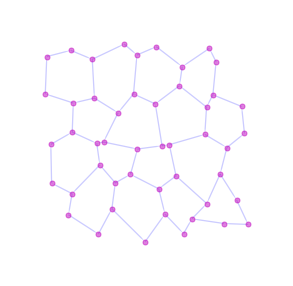

Integration (Euler's method):


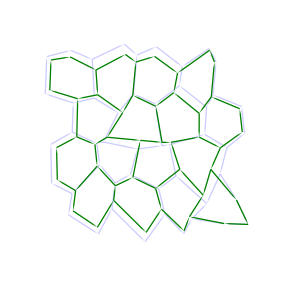

t=1.625: E=0.01989; aver |dx/dt|= 0.01


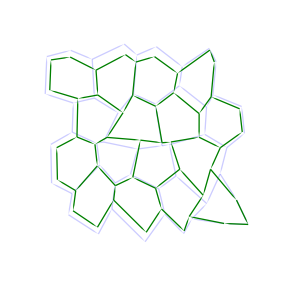

t=4.812: E=0.01801; aver |dx/dt|= 0.0014


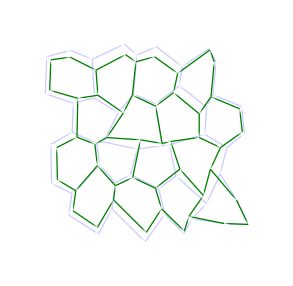

t=9.625: E=0.01737; aver |dx/dt|= 0.0014


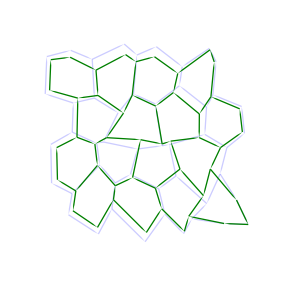

t=12.812: E=0.01692; aver |dx/dt|= 0.0014


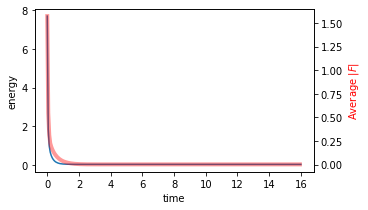

Perimeters:tensor([6.4202, 6.1033, 6.9566, 5.7076, 6.6088, 5.9769, 5.9670, 5.7257, 5.8681,
        5.8884, 5.7165, 5.8964, 5.9936, 5.8844, 5.8885, 6.0749],
       dtype=torch.float64)
Areas:tensor([2.3004, 2.3010, 2.2999, 2.3014, 2.3000, 2.3011, 2.3009, 2.3014, 2.3013,
        2.3013, 2.3016, 2.3012, 2.3009, 2.3013, 2.3011, 2.3008],
       dtype=torch.float64)


In [ ]:
#hide
v_x,regions =unit_hexagons(4,4)
# let's seed RNG for sanity and reproducibility
np.random.seed(24)
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

edge_list,cells = VoronoiRegions2Edges(regions)
# using Voronoi tesselation from above:
verts = Vertex(v_x)
edges = torch.tensor(edge_list)

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=edges, cells=cells)
init_state = Graph(vertices=Vertex(v_x.copy()), edges=edges)
quiver_kwargs={'units': 'xy', 'angles': 'xy', 'scale_units': 'xy',
               'scale': 1.0, 'headwidth': 0, 'headlength': 0, 
               'width': 0.05, 'color': 'b','alpha':.2}
cell_graph.vertices.requires_grad_(True)

# initial state
figsize=[5,5]
plt.figure(figsize=figsize)
plot_graph_as_quiver(cell_graph,quiver_kwargs=quiver_kwargs)
plt.plot(cell_graph.vertices.x[:,0].detach().cpu(),
         cell_graph.vertices.x[:,1].detach().cpu(),'mo',ms=5,alpha=.5)
axs_lims = np.array(plt.axis())
hw = 1.25*(axs_lims[1::2]-axs_lims[0::2])/2
xy_0 = [axs_lims[:2].mean(), axs_lims[2:].mean()]
axs_lims = [xy_0[0]-hw[0],xy_0[0]+hw[0],xy_0[1]-hw[1],xy_0[1]+hw[1]]
plt.axis(axs_lims)
plt.show()
plt.close()

# Define energy function
k=1.0
energy = lambda p,a: torch.sum(.001*(p-7)**2)+torch.sum((a-2.3)**2) #
# Numerical integration
Dt = 2**-4 # time step size
t = [0]
Energies = []
Forces = []
print('Integration (Euler\'s method):')
t_total = 2**8
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    E = energy(cell_graph.perimeter(),cell_graph.area())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    t.append(t[-1]+Dt)
    if round((n+1)%(t_total/10))==0:
        plt.figure(figsize=figsize)
        plot_graph_as_quiver(init_state,quiver_kwargs=quiver_kwargs)
        plot_graph_as_quiver(cell_graph)
        plt.axis(axs_lims)
        plt.show()
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( energy(cell_graph.perimeter(),cell_graph.area()).item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=4)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted vertex_dynamics_models.ipynb.
